# Melbourne Temperature Forecasting

Welcome to another deep learning project. In this project, we will be forecasting the temperature in Melbourne using the Long Short-Term Memory (LSTM) model. The dataset contains the temperature data from 1981 to 1990. The dataset contains the following columns:

1. Date: The date of the observation
2. Temp: The temperature in Melbourne

The dataset is available at the following link: 
https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv

or on the Kaggle website:
https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne

The required libraries will be listed in the next cell for you to install if you don't have them already.

In [ ]:
!pip install -q pandas matplotlib numpy scikit-learn torch

This is the first project in which we are going to be exposed to temporal (time series) data. Recurrent Neural Networks (RNN) are the most popular models for time series forecasting. The Long Short-Term Memory (LSTM) model is a type of RNN that is capable of learning long-term dependencies. But more on the anatomy of the LSTM model later.

For now, we need to load the data, preprocess it, and visualize the data to understand the patterns.

## Instructions

In the next cell:
- Load the dataset into a pandas dataframe
    - Set the 'Date' column as the index
    - Parse the dates, meaning convert the 'Date' column to datetime format
- Plot the data to visualize the temperature patterns

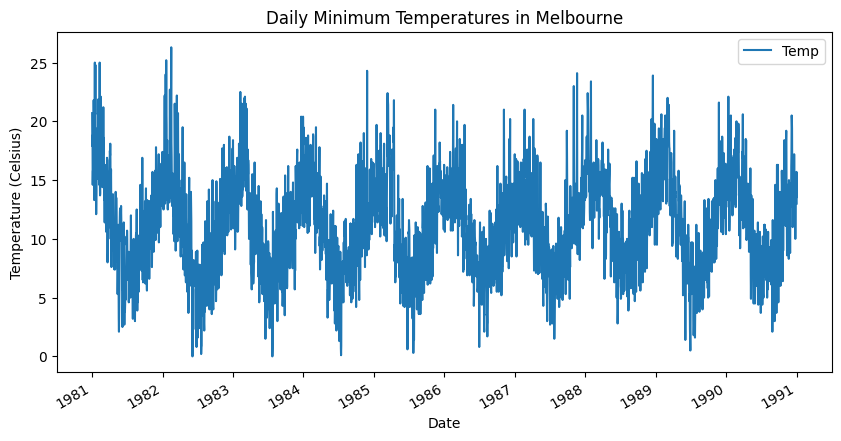

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset by creating a DataFrame and parsing the dates
# Set the Date column as the index
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=["Date"], index_col="Date")

# Plot the data
df.plot(figsize=(10, 5))
plt.title("Daily Minimum Temperatures in Melbourne")
plt.ylabel("Temperature (Celsius)")
plt.xlabel("Date")
plt.show()

Lets see if we can train a model to learn the cyclic patterns in the temperature data and forecast the daily minimum temperature in Melbourne.

If you take a look at the data which you've just plotted, you'll notice that the temperature ranges from 0 to 26 degrees. However, it is good practice to normalize the data before feeding it to the model. This is because the LSTM model is sensitive to the scale of the input data just like most deep learning models.

We will use Scikit-Learn's MinMaxScaler to scale the data. The MinMaxScaler scales the data to a fixed range of 0 to 1 by default, but we will scale it to a range of -1 to 1. This is because the LSTM model uses the hyperbolic tangent activation function, which outputs values in the range of -1 to 1.

## Instructions

We need to scale the data and split it into training and testing sets. LSTM models are fed sequences of data, so we need to create sequences of data to feed to the model. We will use the `TemperatureDataset` class to create PyTorch datasets and dataloaders for the training and testing sets.

A sequence of data, in this case, will be a sequence of 30 days of temperature data. The model will be trained to forecast the temperature on the 31st day given the previous 30 days of temperature data.

We need to implement a custom dataset to make it easier to create sequences of data. When an item is requested from `TemperatureDataset`, it should return a sequence of 30 days (X) of temperature data and the temperature on the 31st day (y).

In the next cell:
- Scale the data using the MinMaxScaler
    - Scale the data to a range of -1 to 1
- Add the scaled data to a new column in the dataframe
- Split the data into training and testing sets
    - Use the first 80% of the data for training and the remaining 20% for testing
- Use the provided `TemperatureDataset` class to create PyTorch datasets and dataloaders for the training and testing sets
    - Set the batch size
    - Shuffle the training dataset sequences (not the testing dataset)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# Preprocess the data by normalizing the temperature values using MinMaxScaler
# which scales the values between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Add a new column to the DataFrame with the normalized values
df["Temp Transformed"] = scaler.fit_transform(df["Temp"].values.reshape(-1, 1))

# Convert the dataframe to a numpy array
all_data = df["Temp Transformed"].values.astype(float)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(all_data) * 0.8)
train_data = all_data[:train_size]
test_data = all_data[train_size:]


# Define a PyTorch Dataset class for sequence generation
class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length):
        # Initialize the dataset with data and sequence length
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # Return the length of the dataset, which is the total number of data points
        # minus the sequence length to ensure we have enough data for the last sequence
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        # Get a sequence of data points starting from the given index
        x = self.data[index : index + self.seq_length]

        # Get the target value which is the next data point after the sequence
        y = self.data[index + self.seq_length]

        # Convert the sequence and target to PyTorch tensors with float32 data type
        return torch.tensor(x, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )


# Set sequence length and batch size
seq_length = 30
batch_size = 32

# Create training and testing datasets using the TemperatureDataset class
train_dataset = TemperatureDataset(train_data, seq_length)
test_dataset = TemperatureDataset(test_data, seq_length)

# Create DataLoaders for training and testing datasets
# Shuffle the training dataset and keep the testing dataset in order
# Use the batch size defined above
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Reflection

We've use the batch size parameter a couple of times now. The batch size is a hyperparameter that defines the number of samples to work through before updating the internal model parameters in the training process. A small batch size can lead to a noisy gradient update, while a large batch size can lead to a slow convergence. The batch size is a trade-off between the accuracy of the model and the speed of training.

## The LSTM Model

Now we need to define the LSTM model. The LSTM model is a type of RNN that is capable of learning long-term dependencies. The LSTM model has three gates: the input gate, the forget gate, and the output gate. The input gate controls the amount of new information to be stored in the cell state. The forget gate controls the amount of information to be discarded from the cell state. The output gate controls the amount of information to be output from the cell state.

To implement our LSTM model, we will use the `nn.LSTM` module provided by PyTorch to learn the temperature patterns in the data and a fully connected layer to make the temperature forecast (linear regression).

In the forward pass, the LSTM model will take the sequence of 30 days of temperature data as input and produce output features at each time step. We will only use the output features at the last time step to make the temperature forecast with the fully connected layer.

We will not use the hidden state or cell state of the LSTM model in this project because we are only interested in forecasting the final value of the sequence.

## Instructions

In the next cell:

- Define the LSTM model
    - Use the `nn.LSTM` module to define the LSTM layer
        - Use the `batch_first=True` parameter to set the input tensor shape as (batch_size, seq_len, input_size)
    - Use the `nn.Linear` module to define the fully connected layer for the temperature forecast
    - Define the forward pass of the model
        - Use the LSTM layer to learn the temperature patterns in the data
        - Use the fully connected layer to make the temperature forecast with the output features at the last time step
- Use the Mean Squared Error (MSE) loss function to calculate the loss
- Use the Adam optimizer to update the model parameters

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np

# Set device to GPU if available (this will speed up the training)
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using device: {device}")


# Define an LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        # Initialize the superclass
        super(LSTMModel, self).__init__()

        # Save the hidden layer size
        self.hidden_layer_size = hidden_layer_size

        # Define the LSTM layer with input size, hidden layer size, and batch_first=True
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # LSTM expects input of shape (batch_size, seq_length, num_features)
        lstm_out, _ = self.lstm(input_seq)

        # Take the output from the last timestep
        predictions = self.linear(lstm_out[:, -1, :])

        # Return the output predictions
        return predictions


# Initialize the model and send it to the device
model = LSTMModel().to(device)

# Initialize the mean squared error loss function
loss_function = nn.MSELoss()

# Use Adam optimizer with learning rate of 0.001 and weight decay of 1e-5
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Gradient clipping to stabilize training
clip_value = 1.0

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0.0  # Initialize the total loss for the epoch
    for seq, labels in train_loader:
        # Move data to the correct device
        seq, labels = seq.to(device), labels.to(device)

        # Reshape input to (batch_size, seq_length, input_size)
        seq = seq.view(-1, seq_length, 1)
        labels = labels.view(-1, 1)  # Reshape labels to match prediction output size

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(seq)

        # Compute the loss
        loss = loss_function(y_pred, labels)

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

        # Update the model parameters by stepping the optimizer
        optimizer.step()

        # Add the batch loss to the epoch loss
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} average loss: {avg_epoch_loss}")

# Testing loop
model.eval()  # Set model to evaluation mode
test_losses = []
with torch.no_grad():
    for seq, labels in test_loader:
        # Move data to the correct device
        seq, labels = seq.to(device), labels.to(device)

        # Reshape input to (batch_size, seq_length, input_size)
        seq = seq.view(-1, seq_length, 1)
        labels = labels.view(-1, 1)  # Reshape labels to match prediction output size

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        test_losses.append(loss.item())

avg_test_loss = np.mean(test_losses)
print(f"Test loss: {avg_test_loss}")

Using device: mps
Epoch 1 average loss: 0.058601762362561385
Epoch 2 average loss: 0.04360365977121906
Epoch 3 average loss: 0.041703207848163754
Epoch 4 average loss: 0.04054054173712547
Epoch 5 average loss: 0.0391132623816912
Epoch 6 average loss: 0.0367618538541617
Epoch 7 average loss: 0.035528941734970274
Epoch 8 average loss: 0.035616140433965805
Epoch 9 average loss: 0.035336969911560906
Epoch 10 average loss: 0.034948554411939864
Test loss: 0.029193092391572216


## Reflection

You may notice some comments and pieces of code related to exploding gradients. The exploding gradient problem occurs when the gradients grow exponentially as they are backpropagated through the network. This can cause the model to fail to learn the patterns in the data.

We fought this using gradient clipping. Gradient clipping is a technique to prevent the gradients from growing too large during training. We can clip the gradients to a maximum value (like 1.0) to prevent them from growing too large.

We also used the weight decay parameter in the optimizer to prevent the model from learning very large weights. The weight decay parameter is a regularization term that penalizes large weights in the model which can lead to overfitting.

Average loss (as opposed to total loss) is a more useful metric for comparing models. The average loss is the total loss divided by the number of batches. This gives us the average loss per batch which is more interpretable than the total loss.

## Generating Predictions and Evaluating the Model

We've already used our test data to evaluate the model during training and compute an average test loss. Now let's generate predictions on our entire dataset.

## Instructions

In the next cell:
- Create a tensor from the entire dataset
- In the training loop:
    - Extract the sequence of 30 days of temperature data from the entire dataset
    - Make a temperature forecast with the LSTM model
    - Append the forecast to the predictions list
- Clip the actual data by the sequence length so it is shifted to match the forecasted data
- Invert the scaling of the forecasted and actual data using the MinMaxScaler we created earlier and its `inverse_transform` method


In [ ]:
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()

# Prepare data for prediction by converting to PyTorch tensor and moving to device
all_data_tensor = torch.tensor(all_data, dtype=torch.float32).to(device)
predictions = []

# Use sliding window to predict temperatures across the whole dataset
with torch.no_grad():
    for i in range(len(all_data) - seq_length):
        # Extract a sequence from the data
        seq = all_data_tensor[i : i + seq_length].view(1, seq_length, 1)

        # Make prediction
        y_pred = model(seq)

        # Save the prediction
        predictions.append(y_pred.item())

# Prepare the actual data (shifted to match the predictions length)
actual_data = all_data[seq_length:]

# Inverse scaling of the data
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_data_inv = scaler.inverse_transform(actual_data.reshape(-1, 1))

## Visualizing the Predictions

Now all that is left to do is to visualize the predictions of the LSTM model! If you want, you can also calculate the Mean Squared Error (MSE) of the predictions to display in the title of the plot.

In the next cell:
- (Optional) Calculate the Mean Squared Error (MSE) of the predictions
- Get the dates starting at the sequence length (for your x-axis)
- Plot the actual and forecasted temperature data

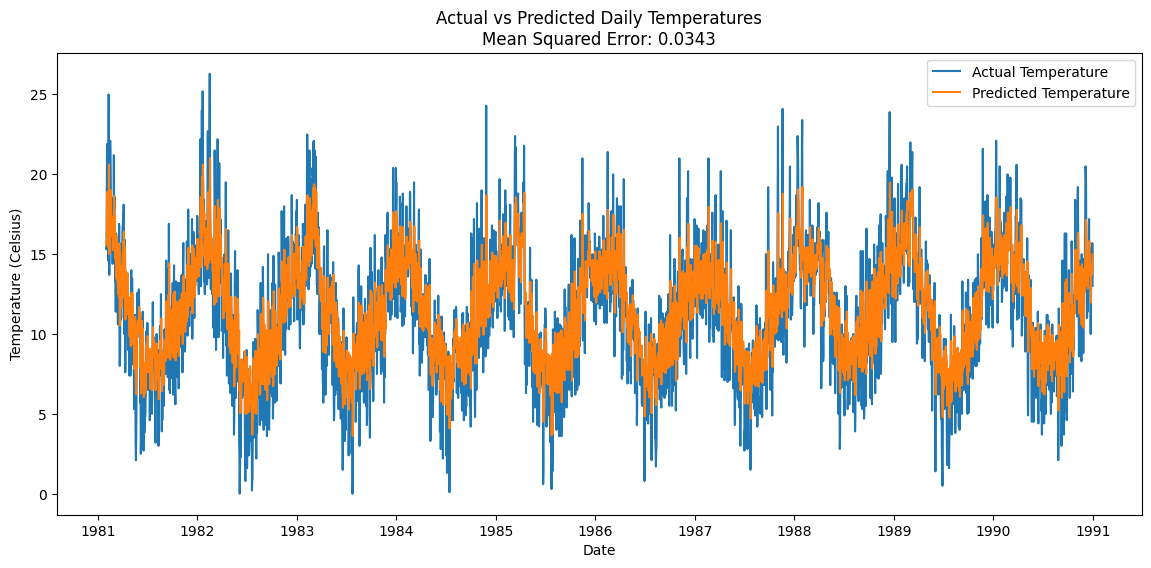

In [90]:
# Calculate the mean squared error
mse = np.mean(np.square(np.array(predictions) - actual_data))

# Convert x axis back to original dates by extracting dates starting from seq_length
# from the original dataframe index
dates = df.index[seq_length:].to_numpy()

# Plotting the results
plt.figure(figsize=(14, 6))
plt.plot(dates, actual_data_inv, label="Actual Temperature")
plt.plot(dates, predictions_inv.flatten(), label="Predicted Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature (Celsius)")
plt.title(f"Actual vs Predicted Daily Temperatures\nMean Squared Error: {mse:.4f}")
plt.legend()
plt.show()

## Final Thoughts

We can see that the LSTM model has learned the cyclic patterns in the temperature data and made accurate temperature forecasts. The LSTM model is a powerful model for time series forecasting because it can learn long-term dependencies in the data. The LSTM model is widely used in various applications such as speech recognition, language modeling, and machine translation.

Notice we did not overfit the model—the forecasted data closely follows the actual data but does not predict outliers.

### Recap

In this project, we learned how to:

- Load and preprocess time series data
- Create sequences of data for the LSTM model
- Define and train an LSTM model
- Generate predictions and evaluate the model
- Visualize the predictions and denormalize the data

## Next Steps

If you are interested in learning more about time series forecasting, try to play around with the hyperparameters of the LSTM model. When you're done, continue on to the next project!